# Chi Square for Outliers

This is a simple method for outlier detection, the procedure basically is a Quantile of weibull distribution of the chi square test in python.

---

The first question is why each part of this process? The proposed approach to this problem is simply to find an observation error, and for that the problem is built on a calculation of Measurement's Accuracy. The procedure is composed of:
* Chi Square test: It can be used to test if the variance of a population is equal to a specified value.
* Weibull Distribution: it can also model skewed data.
* Quantile function: probability distribution of a random variable.

## **Context and Problem Statement**

We may have some small series of data (stock, rolled product thickness, etc.), sometimes the data is collected manually and we need to detect outliers as a first filter to detect human errors in the collected data and correct them before analysis; in other cases, the data must be broken down by season, process, etc. I understand that it is too expensive to do a t-SMN for each variable.


## **Proposed Approach**

The proposed approach to this problem is simply to find an observational error. We cannot establish outlier fences by calculating the interquartile range because this may be used across products and seasons or we do not know the "mathematical" nature of the data. But you can then use a simple Chi-square test and look for errors of observation.

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import variance
from warnings import filterwarnings

In [184]:
sns.set_style("whitegrid")
#
filterwarnings('ignore')
#
palette =['#44445599','#99222299']

---

In [185]:
RawData = pd.read_csv('RawData.csv', index_col='Date')

In [186]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 7/31/2015 to 1/2/2013
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Customers  781 non-null    int64
dtypes: int64(1)
memory usage: 12.2+ KB


In [187]:
RawData.head()

,Customers
Date,
7/31/2015,555
7/30/2015,546
7/29/2015,523
7/28/2015,560
7/27/2015,612


<AxesSubplot:xlabel='Customers', ylabel='Density'>

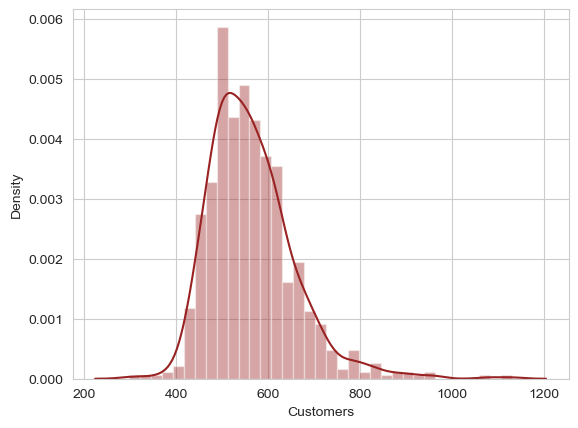

In [188]:
sns.distplot(RawData['Customers'], color=palette[1])

In [189]:
ZeroData = RawData[RawData['Customers'] == 0].copy()

In [190]:
ZeroData

,Customers
Date,


In [191]:
RawData=RawData.drop(RawData[RawData['Customers'] == 0].index)

### Measurement's Accuracy

* literature of kalman filter
    * MeasurementAccuracy = lista['value'][i] - lista['value'].median()
* Proposed
    * MeasurementAccuracy = lista['value'][i] / lista['value'].median()


In [192]:
μ = RawData['Customers'].median()
n = len(RawData['Customers'])

MeasurementAccuracy = []
for i in range(n):
    MAtemp = (RawData['Customers'][i] / μ)
    MeasurementAccuracy.append(MAtemp)

RawData['MeasurementAccuracy'] = MeasurementAccuracy



<AxesSubplot:xlabel='MeasurementAccuracy', ylabel='Density'>

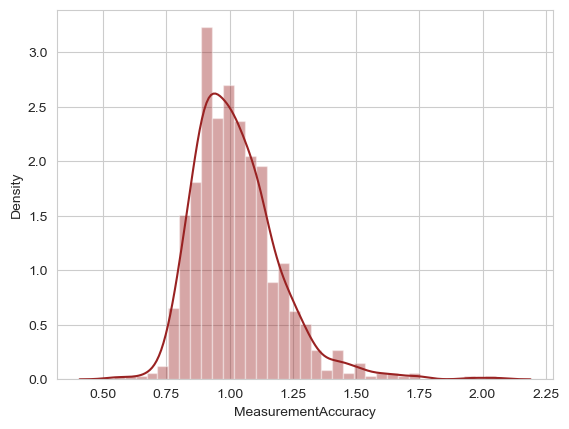

In [193]:
sns.distplot(RawData['MeasurementAccuracy'], color=palette[1])

### Chi-square test for variance
image.png

In [194]:
#σS = the sample variance

σ = variance(RawData['MeasurementAccuracy'])# the population variance σ²
x2 = []
for i in range(n):
        if i>0:
                σS = variance([RawData['MeasurementAccuracy'][i],RawData['MeasurementAccuracy'][i-1]])# Because the sample is this and the past data
                x2t = ( (n-1) * σS ) / σ
                x2.append(x2t)
        else: x2.append(0)

RawData['χ2'] = x2



[None]

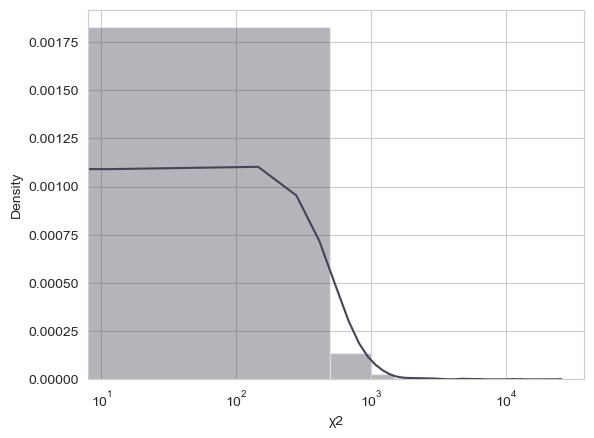

In [195]:
sns.distplot(RawData['χ2'], color=palette[0]).set(xscale="log")

In [196]:
x2q = np.quantile(RawData['χ2'], 0.95, method='weibull')
x2q

854.4513341888082

In [197]:
RawData['Type'] = 0
for i in range(len(RawData['χ2'])):
    if RawData['χ2'][i] > x2q: RawData['Type'][i] = 'Noise'
    else: RawData['Type'][i] = 'Data'

In [198]:
RawData['Type'].value_counts()

Data     742
Noise     39
Name: Type, dtype: int64

[None]

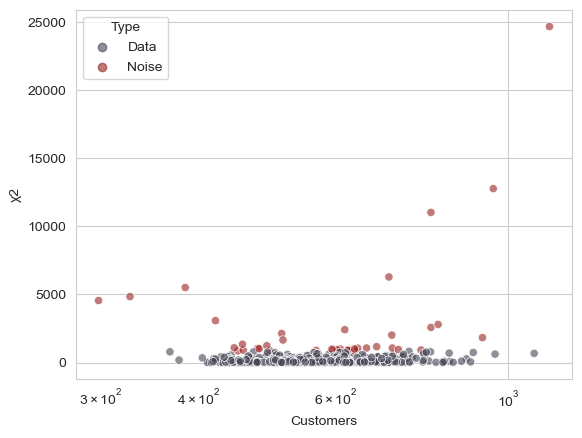

In [199]:
sns.scatterplot( x=RawData['Customers'], y=RawData['χ2'], data=RawData, hue=RawData['Type'],
                    palette=palette, legend='full').set(xscale="log")

In [200]:
l2 = RawData[RawData['χ2'] > x2q].copy()
l2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 6/5/2015 to 1/5/2013
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customers            39 non-null     int64  
 1   MeasurementAccuracy  39 non-null     float64
 2   χ2                   39 non-null     float64
 3   Type                 39 non-null     object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [201]:
(len(l2)/len(RawData))*100

4.99359795134443

[None]

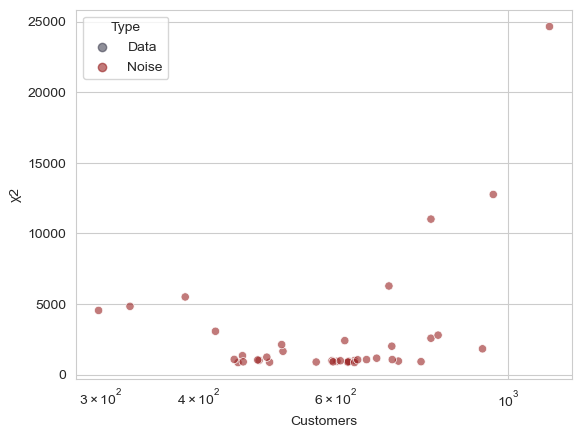

In [202]:
sns.scatterplot( x=l2['Customers'], y=l2['χ2'], data=l2, hue=RawData['Type'],
                    palette=palette, legend='full').set(xscale="log")

In [203]:
l3 = RawData[RawData['χ2'] <= x2q].copy()

[None]

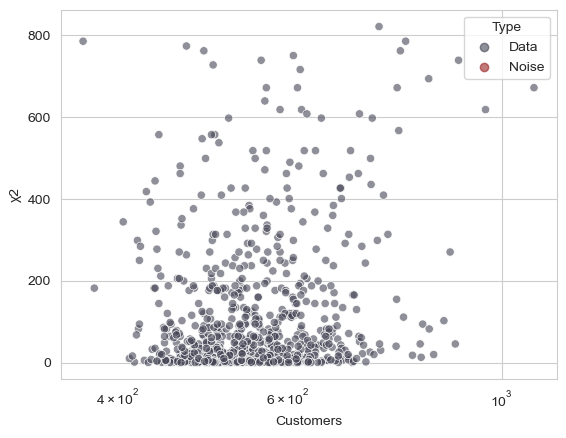

In [204]:
sns.scatterplot( x=l3['Customers'], y=l3['χ2'], data=l3, hue=RawData['Type'],
                    palette=palette, legend='full').set(xscale="log")

### Sources

* [Empirical Methods](https://www.empirical-methods.hslu.ch/) @ Hochschule Luzern
* [NIST/SEMATECH](https://www.itl.nist.gov/div898/handbook/eda/section3/eda358.htm) e-Handbook of Statistical Methods
* Introduction to Statistical Quality Control by DOUGLAS C. MONTGOMERY
* [dataset for exercise](https://medium.com/r/?url=https%3A%2F%2Fwww.kaggle.com%2Fcompetitions%2Frossmann-store-sales%2Fdata%3Fselect%3Dtrain.csv)